<h3>Classification d'Images avec Data Augmentation (image en Noir et Blanc)<h3/>

In [43]:
###========================================================================
# Importations et Configuration
###========================================================================

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset, Subset
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix


# Configuration de l'appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil: {device}")

Utilisation de l'appareil: cpu


In [44]:
###========================================================================
# Transformation de Base (Normalisation)
###========================================================================

# Transformation de base : Redimensionnement, ToTensor, Normalisation
BASE_TRANSFORM = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Charger les données avec ImageFolder et la transformation de base
dataset = datasets.ImageFolder(root="data_img", transform=BASE_TRANSFORM)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True) #  nb_batch = nb_data / 32

print("Classes:", dataset.classes)
print("Index des classes:", dataset.class_to_idx)
print(len(dataset))

Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Index des classes: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
26179


In [45]:
###========================================================================
# Sélection d'un Échantillon (Sous-échantillonnage)
###========================================================================

# --- Configuration ---
# Remplacez 'dataset' et 'data_loader' par vos objets PyTorch respectifs
# dataset = datasets.ImageFolder(root="data_img", transform=BASE_TRANSFORM) 
# data_loader = DataLoader(dataset, batch_size=32, shuffle=True) 

max_images_per_class = 1000 
num_classes = len(dataset.classes) # Nombre total de classes

# Dictionnaires pour stocker les images et labels
class_images = defaultdict(list)
class_labels = defaultdict(list)

print(f"Collecte de {max_images_per_class} images par classe...")

# --- Logique de Collecte Optimisée ---
# Utilise un ensemble (set) pour un look-up rapide
classes_to_collect = set(range(num_classes))
classes_finished = set()

for images, labels in data_loader:
    # Parcourir les images du lot
    for image, label in zip(images, labels):
        label_item = label.item()
        
        # Vérifier si on a déjà atteint la limite pour cette classe
        if label_item in classes_finished:
            continue
            
        # Ajouter l'image et le label
        class_images[label_item].append(image)
        class_labels[label_item].append(label_item)
        
        # Vérifier si la classe a atteint sa limite
        if len(class_images[label_item]) >= max_images_per_class:
            classes_finished.add(label_item)
            
    # Condition d'arrêt : Vérification après le lot
    if len(classes_finished) == num_classes:
        break

# --- Vérification Finale (Non nécessaire avec la logique ci-dessus, mais gardée par sécurité) ---
# S'assure que toutes les listes ne dépassent pas max_images_per_class
for class_idx in class_images:
    class_images[class_idx] = class_images[class_idx][:max_images_per_class]
    class_labels[class_idx] = class_labels[class_idx][:max_images_per_class]

# --- Affichage Final ---
print("\nNombre d'images par classe après sous-échantillonnage :")
for class_idx in sorted(class_images.keys()):
    count = len(class_images[class_idx])
    print(f"Classe {dataset.classes[class_idx]} : {count} images")

if len(classes_finished) < num_classes:
    print(f"\n Avertissement: Seulement {len(classes_finished)}/{num_classes} classes ont atteint {max_images_per_class} images (la fin du dataset a été atteinte).")

Collecte de 1000 images par classe...

Nombre d'images par classe après sous-échantillonnage :
Classe cane : 1000 images
Classe cavallo : 1000 images
Classe elefante : 1000 images
Classe farfalla : 1000 images
Classe gallina : 1000 images
Classe gatto : 1000 images
Classe mucca : 1000 images
Classe pecora : 1000 images
Classe ragno : 1000 images
Classe scoiattolo : 1000 images


In [46]:
# Définition des Datasets pour l'Augmentation
###========================================================================
# Classes de Dataset pour la Manipulation de Tenseurs
###========================================================================

class SubsetTensorDataset(Dataset):
    """Encapsule les tenseurs d'images collectés et normalisés."""
    def __init__(self, class_images, class_labels):
        self.images = []
        self.labels = []
        for label, images in class_images.items():
            self.images.extend(images)
            self.labels.extend([label] * len(images))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class AugmentedSubset(Dataset):
    """Applique une transformation spécifique (e.g., RandomErasing) à un Subset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            # Application de la transformation (Random Erasing) sur le tenseur
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

<h3>Division train/test/valid et application des transformations<h3/>

In [ ]:
###========================================================================
# Division et Application de Random Erasing
###========================================================================


# Créer le dataset de base avec les tenseurs collectés
base_dataset = SubsetTensorDataset(class_images, class_labels)
#base_dataset = dataset

# --- Paramètres de division ---

TRAIN_RATIO = 0.8
VALID_TEST_RATIO = 0.5 # 50% de la partie restante (20%) va à Valid et 50% à Test

total_size = len(base_dataset)
train_size = int(TRAIN_RATIO * total_size)
valid_test_size = total_size - train_size # Reste 20%

# 1. Division: Train et (Valid + Test)
train_indices, valid_test_indices = random_split(base_dataset, [train_size, valid_test_size])

# 2. Division: Valid et Test (à partir des 20% restants)
valid_size = int(VALID_TEST_RATIO * valid_test_size)
test_size = valid_test_size - valid_size # Assure que la somme est égale à valid_test_size

valid_indices, test_indices = random_split(valid_test_indices, [valid_size, test_size])



# --- Paramètres de la transformation ---

# Définition de Random Erasing (Suppression de zone)
# Il ne fait que la suppression de zone, car les autres étapes sont déjà faites.
# Convertit aléatoirement l'image en niveaux de gris avec une probabilité p
RANDOM_GRAYSCALE_TRANSFORM = transforms.RandomGrayscale(
    p=1 # 100% de chance de convertir l'image en niveaux de gris
)

# --- Création des Datasets et DataLoaders ---

# 1. Train Loader (AVEC Grayscale)
train_dataset = AugmentedSubset(train_indices, transform=RANDOM_GRAYSCALE_TRANSFORM)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. Validation Loader (SANS augmentation)
valid_dataset = AugmentedSubset(valid_indices, transform=None)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 3. Test Loader (SANS augmentation)
test_dataset = AugmentedSubset(test_indices, transform=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Suppression des variables intermédiaires pour la clarté
del valid_test_indices

# 4. Train Loader (SANS augmentation)
# On utilise la classe AugmentedSubset, mais on passe transform=None
train_dataset_no_aug = AugmentedSubset(train_indices, transform=None) 
train_loader_no_aug = torch.utils.data.DataLoader(
    train_dataset_no_aug, 
    batch_size=32, 
    shuffle=True
)


# 3. Fusionner les deux datasets
# Le dataset final aura une taille double, contenant l'image A et l'image A augmentée.
combined_train_dataset = ConcatDataset([train_dataset, train_dataset_no_aug])

# 4. Créer un seul DataLoader
# Assurez-vous d'utiliser shuffle=True pour mélanger les lots augmentés et non augmentés.
combined_train_loader = torch.utils.data.DataLoader(
    combined_train_dataset, 
    batch_size=32, 
    shuffle=True
)

print(f"Tailles des ensembles : Train_combined={len(combined_train_dataset)}, Validation={valid_size}, Test={test_size}, Total={ total_size + len(combined_train_dataset)}")


Tailles des ensembles : Train_combined=16000, Validation=1000, Test=1000, Total=26000


In [48]:
print(f"train={len(train_dataset)}, Validation={valid_size}, Test={test_size}")

train=8000, Validation=1000, Test=1000


In [ ]:
###========================================================================
# Visualisation de l'Augmentation
###========================================================================

# Définition de la fonction de dénormalisation (imshow)
def imshow(img, title=None):
    """Dé-normalise et affiche une image (tenseur PyTorch)"""
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    # Dé-normalisation
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1) 
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# ----------------------------------------------------------------------

def visualize_augmentation(base_dataset, transform_aug, class_id=None, image_index_in_class=None):
    """
    Visualise une image spécifique du jeu de données, avec et sans Random Erasing.

    Args:
        base_dataset (Dataset): Votre dataset initial (ImageFolder ou SubsetTensorDataset).
        transform_aug : La transformation d'augmentation à appliquer.
        class_id (int, optional): L'ID de la classe à visualiser.
        image_index_in_class (int, optional): L'index de l'image DANS cette classe.
    """
    
    # 1. Préparation des indices optimisée
    class_indices = defaultdict(list)
    
    if isinstance(base_dataset, ImageFolder):
        # 🔑 OPTIMISATION pour ImageFolder : Utiliser les attributs internes
        # base_dataset.targets contient la liste de tous les labels (index)
        for idx, label in enumerate(base_dataset.targets):
            class_indices[label].append(idx)
    elif hasattr(base_dataset, 'labels'):
         # Optimisation pour la classe SubsetTensorDataset
        for idx, label in enumerate(base_dataset.labels):
            class_indices[label].append(idx)
    else:
        # Solution lente de secours pour les autres types de Dataset
        print("Avertissement: Utilisation d'une boucle lente pour la recherche d'indices.")
        for idx, (img, label) in enumerate(base_dataset):
            class_indices[label].append(idx)

    # 2. Sélection de la classe et de l'index (Le reste de la logique de sélection est conservé)
    
    if not class_indices:
        print("Aucune image trouvée dans le dataset.")
        return

    if class_id is None:
        class_id = random.choice(list(class_indices.keys()))
    
    if class_id not in class_indices:
        print(f"La classe {class_id} n'a pas été trouvée dans le base_dataset.")
        return

    if image_index_in_class is None:
        image_index_in_class = random.randrange(len(class_indices[class_id]))

    try:
        global_index = class_indices[class_id][image_index_in_class]
    except IndexError:
        print(f"L'indice {image_index_in_class} est hors limites pour la classe {class_id} (max {len(class_indices[class_id])-1}).")
        return

    # 3. Extraction et Augmentation
    
    # L'accès à base_dataset[global_index] lit et transforme l'image UNE SEULE FOIS.
    image_orig, label_idx = base_dataset[global_index]
    
    # Appliquer manuellement la transformation d'augmentation
    image_aug = transform_aug(image_orig.clone())

    # 4. Affichage
    
    # Si base_dataset est ImageFolder, il a l'attribut .classes
    if hasattr(base_dataset, 'classes'):
        class_name = base_dataset.classes[label_idx]
    else:
        # Utiliser l'ancienne logique si le nom des classes n'est pas directement accessible
        class_name = f"Classe {label_idx}"
    
    print(f"Visualisation de l'image [Local: {image_index_in_class}, Global: {global_index}] de la classe '{class_name}':")

    # Nom de la transformation appliquée
    transform_name = transform_aug.__class__.__name__  # Récupère le nom de la classe de la transformation
    
    # Créez le titre avec le nom de la transformation
    original_title = f"Original - {class_name}"
    augmented_title = f"Augmentée ({transform_name}) - {class_name}"

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    plt.sca(axes[0])
    imshow(image_orig.cpu(), title=original_title)
    plt.sca(axes[1])
    imshow(image_aug.cpu(), title=augmented_title)
    plt.tight_layout()
    plt.show()


--- 1. Exemple Aléatoire ---
Visualisation de l'image [Local: 777, Global: 18453] de la classe 'pecora':


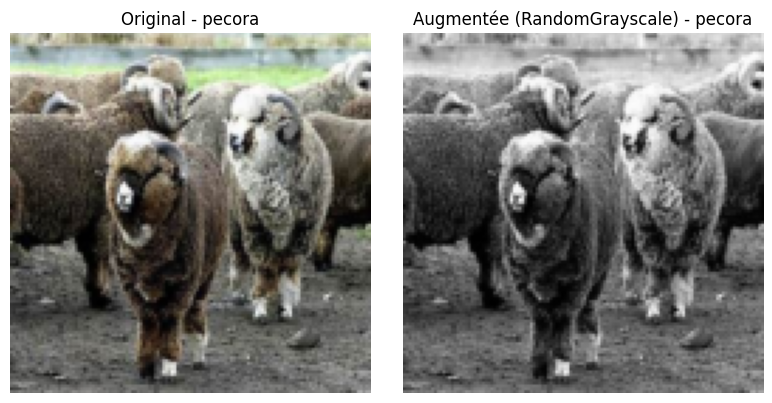

Visualisation de l'image [Local: 2, Global: 2] de la classe 'cane':


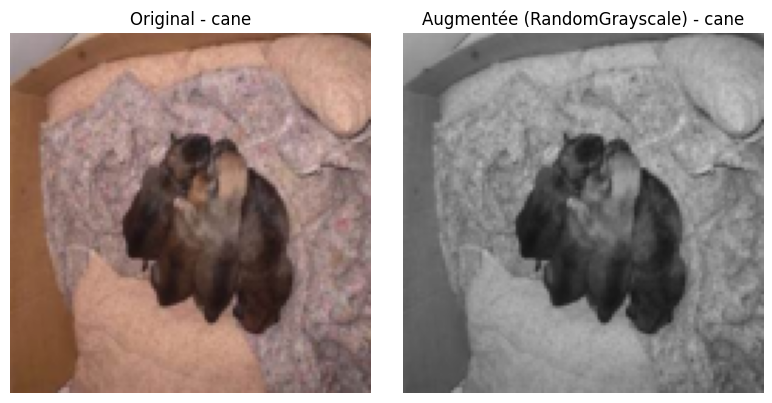

In [50]:
# --- APPEL ---

# 1. Sélection Aléatoire (par défaut)
print("--- 1. Exemple Aléatoire ---")
visualize_augmentation(dataset, RANDOM_GRAYSCALE_TRANSFORM) 

# 2. Sélection Spécifique (Classe 0, 3e image)
visualize_augmentation(dataset, RANDOM_GRAYSCALE_TRANSFORM, class_id=0, image_index_in_class=2)

In [51]:
###========================================================================
# Définition du Modèle 
###========================================================================

class CNN_Animals(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # Taille d'entrée pour la FC: 128x128 -> (pool x3) -> 16x16
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNN_Animals(num_classes=len(dataset.classes)).to(device)
print(model)

CNN_Animals(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [52]:
# Modèle CNN et Fonctions d'Entraînement/Test
###========================================================================
# Boucles d'Entraînement et de Test
###========================================================================

def train_loop(loader, model, loss_fn, optimizer, log=True):
    model.train()
    total_loss = 0
    size = len(loader.dataset)

    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)

        # Forward
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if log and batch % 10 == 0:
            current = (batch + 1) * len(X)
            # batch_size_actual = len(X) # Taille réelle du lot # [Taille lot: {batch_size_actual:>2d}]
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
            

    avg_loss = total_loss / len(loader)
    print(f"🔹 Moyenne de la loss sur l'époque : {avg_loss:.4f}")
    return avg_loss

def test_loop(loader, model, loss_fn, log=True):
    model.eval()
    size = len(loader.dataset)
    num_batches = len(loader)
    test_loss, correct = 0, 0

    # Listes pour collecter toutes les prédictions et tous les labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # Collecte des prédictions et des labels
            predictions = pred.argmax(1)
            correct += (predictions == y).type(torch.float).sum().item()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    accuracy = correct / size

    # Calcul des métriques avancées avec scikit-learn
    
    # Le mode 'macro' traite toutes les classes avec le même poids (utile pour les classes déséquilibrées)
    # Le mode 'weighted' pondère les scores par le nombre d'échantillons de chaque classe
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    
    # Génération de la Matrice de Confusion
    conf_matrix = confusion_matrix(all_labels, all_preds)

    if log:
        print(f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, loss: {test_loss:>8f} ")
        print("-" * 30)
        print(f"Metrics (Macro Avg.):")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print("-" * 30)
        # Vous pouvez aussi afficher la matrice de confusion à la fin de l'entraînement
        # print("Matrice de Confusion:\n", conf_matrix)
        
    # Retourne la loss, l'accuracy et le score F1 macro
    return test_loss, 100 * accuracy, f1

In [53]:
# --- Fonction pour résumer les résultats ---
def res():
    print("Loss    ", "Init: ", loss_test_[0], "           Final: ", loss_test_[len(loss_test_)-1])
    print("Accuracy", "Init: ", acc_valid_[0], "           Final: ", acc_valid_[len(acc_valid_)-1], "%")
    print("F1 Score", "Init: ", f1_valid_[0], "         Final: ", f1_valid_[len(f1_valid_)-1])


# --- Fonction pour tracer les courbes ---
def plot_res() : 
    # Tracé des courbes (utilisant les données de VALIDATION)
    plt.figure(figsize=(18, 5))

    # 1. Courbe de Perte
    plt.subplot(1, 3, 1)
    plt.plot(loss_train_, label='Train Loss')
    plt.plot(loss_test_, label='Validation Loss')
    plt.title('Courbe de Perte')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Courbe d'Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(acc_valid_, label='Validation Accuracy', color='green')
    plt.title("Courbe d'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Précision (%)')
    plt.legend()
    plt.grid(True)

    # 3. Courbe du F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(f1_valid_, label='Validation F1 Score', color='purple')
    plt.title('Courbe du F1 Score')
    plt.xlabel('Époque')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [64]:
###========================================================================
# Entraînement Final données augmentées
###========================================================================

epochs = 20
loss_test_ = []
loss_train_ = []
acc_valid_ = []
f1_valid_ = []

if 'model' in locals():
    del model
    print("model supp")


model = CNN_Animals(num_classes=len(dataset.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for t in range(epochs):
    print(f"\n===== Époque {t+1} =====")
    # Entraînement avec data augmentation
    loss_train_.append(train_loop(combined_train_loader, model, loss_fn, optimizer))
    # Évaluation sans data augmentation (loss, accuracy, f1_score)
    l_, a_, f_ = test_loop(valid_loader, model, loss_fn) 
    loss_test_.append(l_) # Loss de Validation
    acc_valid_.append(a_) # Accuracy de Validation
    f1_valid_.append(f_)  # F1 Score de Validation

print("Done!")

res()

model supp

===== Époque 1 =====
loss: 2.297412  [   32/16000]
loss: 2.298261  [  352/16000]
loss: 2.291568  [  672/16000]
loss: 2.301940  [  992/16000]
loss: 2.294743  [ 1312/16000]
loss: 2.290097  [ 1632/16000]
loss: 2.302240  [ 1952/16000]
loss: 2.298921  [ 2272/16000]
loss: 2.305113  [ 2592/16000]
loss: 2.305591  [ 2912/16000]
loss: 2.300456  [ 3232/16000]
loss: 2.291877  [ 3552/16000]
loss: 2.293768  [ 3872/16000]
loss: 2.301145  [ 4192/16000]
loss: 2.298843  [ 4512/16000]
loss: 2.265010  [ 4832/16000]
loss: 2.277983  [ 5152/16000]
loss: 2.295575  [ 5472/16000]
loss: 2.308863  [ 5792/16000]
loss: 2.289968  [ 6112/16000]
loss: 2.287467  [ 6432/16000]
loss: 2.283625  [ 6752/16000]
loss: 2.270371  [ 7072/16000]
loss: 2.269025  [ 7392/16000]
loss: 2.287439  [ 7712/16000]
loss: 2.294887  [ 8032/16000]
loss: 2.279739  [ 8352/16000]
loss: 2.271602  [ 8672/16000]
loss: 2.262340  [ 8992/16000]
loss: 2.282173  [ 9312/16000]
loss: 2.249261  [ 9632/16000]
loss: 2.266062  [ 9952/16000]
loss: 2

In [55]:
res()

Loss     Init:  2.300852134823799            Final:  1.9441901184618473
Accuracy Init:  9.3            Final:  32.0 %
F1 Score Init:  0.03096598639455782          Final:  0.3138594413558193


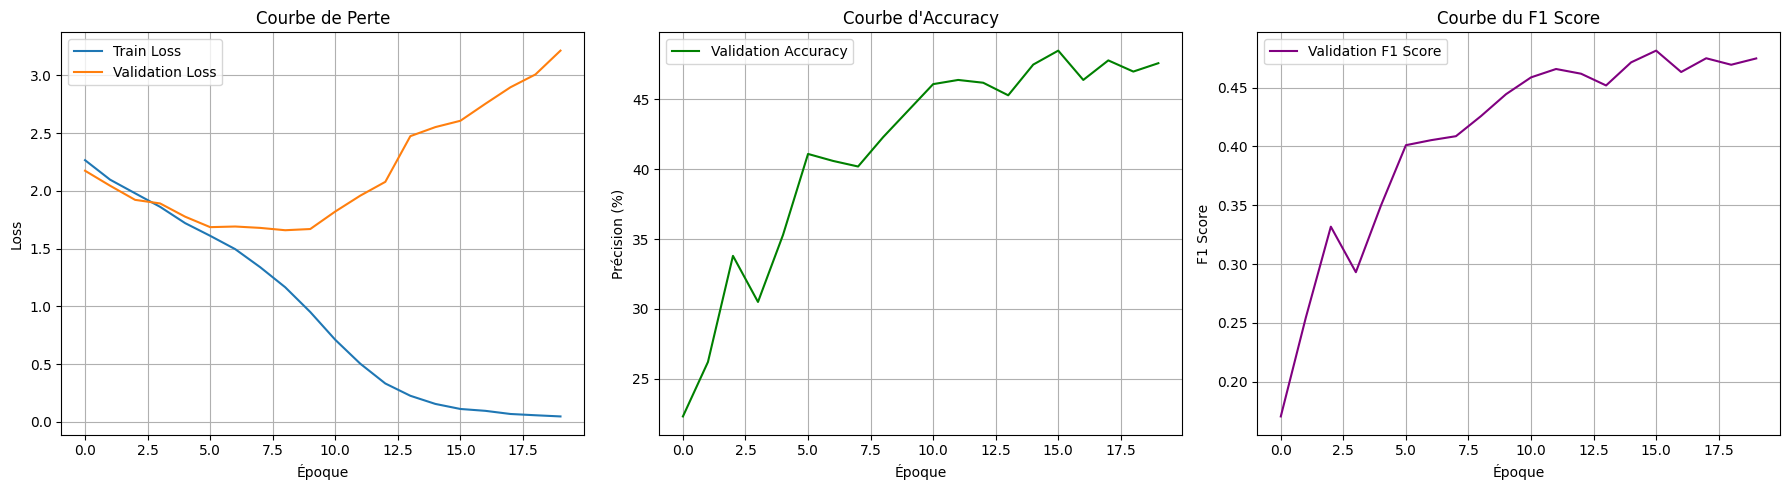

In [66]:
plot_res()

<h3>Évaluation Finale sur le jeu de donnée Test <h3/>

In [57]:
print("\n" + "="*50)
print(" Évaluation Finale sur l'ENSEMBLE de TEST ")
print("="*50)

# Utilisation du test_loader pour l'évaluation finale
test_loss_final, test_acc_final, test_f1_final = test_loop(test_loader, model, loss_fn, log=True)

print(f"\nRESULTATS FINAUX SUR LE JEU DE TEST ({test_size} échantillons) :")
print(f"  - Perte (Loss): {test_loss_final:.4f}")
print(f"  - Précision (Accuracy): {test_acc_final:.1f}%")
print(f"  - F1 Score (Macro): {test_f1_final:.4f}")

res()


 Évaluation Finale sur l'ENSEMBLE de TEST 
Test Error: 
 Accuracy: 31.6%, loss: 1.941234 
------------------------------
Metrics (Macro Avg.):
  Precision: 0.3189
  Recall:    0.3160
  F1 Score:  0.3097
------------------------------

RESULTATS FINAUX SUR LE JEU DE TEST (1000 échantillons) :
  - Perte (Loss): 1.9412
  - Précision (Accuracy): 31.6%
  - F1 Score (Macro): 0.3097
Loss     Init:  2.300852134823799            Final:  1.9441901184618473
Accuracy Init:  9.3            Final:  32.0 %
F1 Score Init:  0.03096598639455782          Final:  0.3138594413558193


In [58]:
res()

Loss     Init:  2.300852134823799            Final:  1.9441901184618473
Accuracy Init:  9.3            Final:  32.0 %
F1 Score Init:  0.03096598639455782          Final:  0.3138594413558193


<h3> Entraînement sans Augmentation <h3/>

In [60]:
###========================================================================
# Entraînement Final sans augmentation
###========================================================================

epochs = 20
loss_test = []
loss_train = []
acc_test = []
f1_test = []

if 'model' in locals():
    del model
    print("model supp")


model = CNN_Animals(num_classes=len(dataset.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for t in range(epochs):
    print(f"\n--- Époque {t+1} (SANS Augmentation) ---")
    # Entraînement avec data augmentation
    loss_train.append(train_loop(train_loader_no_aug, model, loss_fn, optimizer))
    # Évaluation sans data augmentation (loss, accuracy, f1_score)
    l, a, f = test_loop(valid_loader, model, loss_fn) 
    loss_test.append(l)
    acc_test.append(a)
    f1_test.append(f)
print("Done!")

res()

model supp

--- Époque 1 (SANS Augmentation) ---
loss: 2.309645  [   32/ 8000]
loss: 2.306942  [  352/ 8000]
loss: 2.299423  [  672/ 8000]
loss: 2.289228  [  992/ 8000]
loss: 2.305815  [ 1312/ 8000]
loss: 2.304834  [ 1632/ 8000]
loss: 2.281804  [ 1952/ 8000]
loss: 2.297604  [ 2272/ 8000]
loss: 2.311824  [ 2592/ 8000]
loss: 2.305559  [ 2912/ 8000]
loss: 2.291687  [ 3232/ 8000]
loss: 2.298277  [ 3552/ 8000]
loss: 2.298519  [ 3872/ 8000]
loss: 2.296546  [ 4192/ 8000]
loss: 2.287254  [ 4512/ 8000]
loss: 2.286057  [ 4832/ 8000]
loss: 2.297282  [ 5152/ 8000]
loss: 2.273806  [ 5472/ 8000]
loss: 2.306637  [ 5792/ 8000]
loss: 2.290335  [ 6112/ 8000]
loss: 2.302288  [ 6432/ 8000]
loss: 2.295585  [ 6752/ 8000]
loss: 2.283278  [ 7072/ 8000]
loss: 2.298105  [ 7392/ 8000]
loss: 2.307102  [ 7712/ 8000]
🔹 Moyenne de la loss sur l'époque : 2.2968
Test Error: 
 Accuracy: 9.8%, loss: 2.289907 
------------------------------
Metrics (Macro Avg.):
  Precision: 0.1583
  Recall:    0.1142
  F1 Score:  0.0453

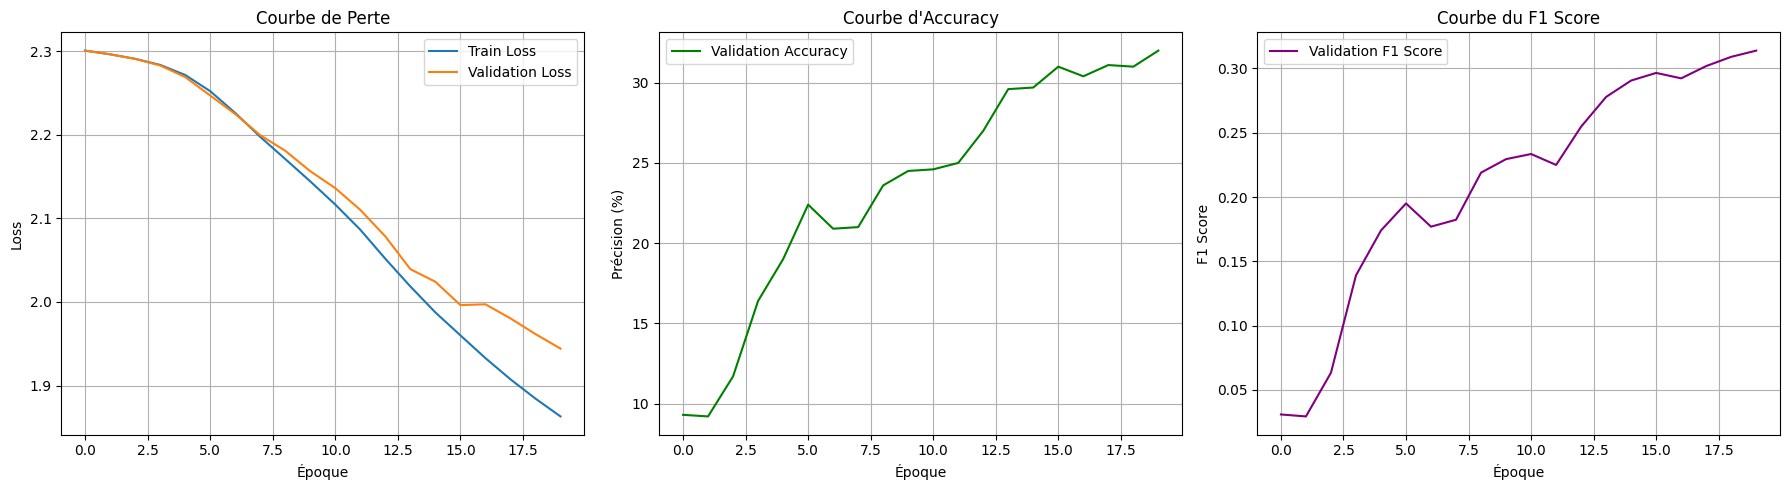

In [61]:
###========================================================================
# Tracé des Résultats
###========================================================================

# Tracé des courbes
plot_res()

In [145]:
res()

Loss     Init:  2.2276705212709382            Final:  2.18014000683296
Accuracy Init:  18.220015278838808            Final:  22.650878533231474 %
F1 Score Init:  0.0312065292181684          Final:  0.06860655854714774


<p> Sans augmentation learn y = 1e-3 ; adam <p/>
<p> Loss     Init:  1.3512092952321215            Final:  1.014780085988161 <p/>
<p> Accuracy Init:  53.7433155080214            Final:  67.3414820473644 % <p/>
<p> F1 Score Init:  0.49264617865110233          Final:  0.642271303218783 <p/>
<p> nb epoch opt = 4 pour la valid loss et 2 pour accuracy et F1 score <p/>


<p> Sans augmentation learn y = 1e-4 ; adam <p/>
<p> Loss     Init:  1.7326274019915884            Final:  1.3378207218356248 <p/>
<p> Accuracy Init:  39.49579831932773            Final:  54.736440030557674 % <p/>
<p> F1 Score Init:  0.30294142585012596          Final:  0.49925118199103957 <p/>
<p> nb epoch opt = 4 pour la valid loss et 2 pour accuracy et F1 score <p/>

Visualisation de l'image [Local: 2, Global: 2] de la classe 'butterfly':


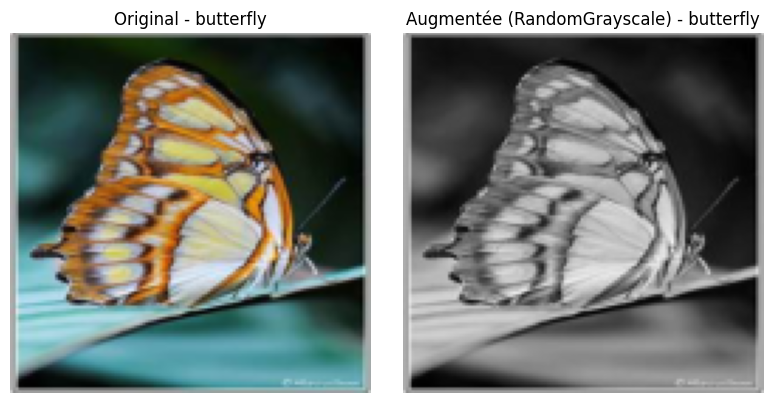

In [298]:
#for i in range(2):
#    visualize_augmentation(dataset, SHARPNESS_TRANSFORM, class_id=3)
#visualize_augmentation(dataset, SHARPNESS_TRANSFORM, class_id=2, image_index_in_class=9)
#visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM_SP_B, class_id=1, image_index_in_class=19)
#visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM_SP_B, class_id=6, image_index_in_class=19)
#visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM_SP_W, class_id=0, image_index_in_class=2)
visualize_augmentation(dataset, RANDOM_GRAYSCALE_TRANSFORM, class_id=0, image_index_in_class=2)
#visualize_augmentation(dataset, PATCH_SHUFFLE_TRANSFORM, class_id=6)

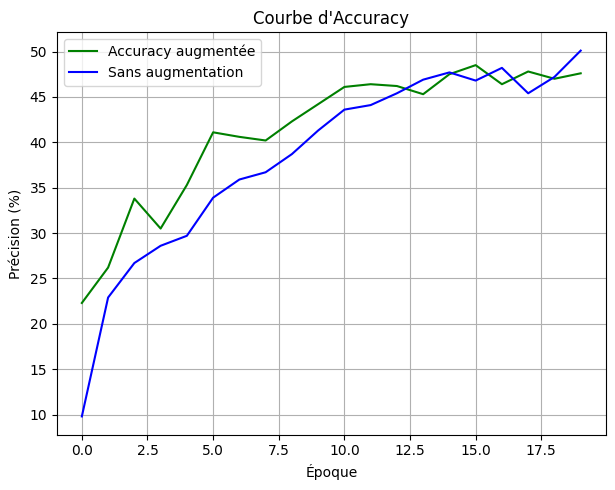

In [65]:
def plot_res_c(accuracy_1,accuracy_2) : 
    # Tracé des courbes (utilisant les données de VALIDATION)
    plt.figure(figsize=(18, 5))

   

    # 2. Courbe d'Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(accuracy_1, label='Accuracy augmentée', color='green')
    plt.plot(accuracy_2, label='Sans augmentation', color='blue')
    plt.title("Courbe d'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Précision (%)')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

plot_res_c(acc_valid_,acc_test)